# 1. Overview & Objectives  
Datasource: https://dev.meteostat.net/bulk/

This notebook aims to provide a cleaned, imputed daily weather dataset for Michigan (1980–2025) ready for time series modeling and visualization. All missing data will be addressed using a combination of vectorized calculations, climatology, and machine learning.

As final output a .csv file will be generated and saved in the folder data\processed.


# 2. Imports & Setup

In [ ]:
import sys
import subprocess

subprocess.check_call([sys.executable, "-m", "ensurepip", "--upgrade"]) #ensure pip is installed


0

In [ ]:
!"{sys.executable}" -m pip install meteostat #install meteostat package

  Using cached meteostat-1.7.6-py3-none-any.whl.metadata (4.6 kB)
Using cached meteostat-1.7.6-py3-none-any.whl (33 kB)



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
# Import Meteostat library
from meteostat import Stations
from meteostat import Point, Daily

In [10]:
from datetime import datetime
import matplotlib.pyplot as plt

import pandas as pd

In [ ]:
# pip install scikit-learn

  Using cached scikit_learn-1.7.2-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.7.2-cp312-cp312-win_amd64.whl (8.7 MB)
Using cached joblib-1.5.2-py3-none-any.whl (308 kB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [41]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# 3. Load Data from website

### Load stations data

In [11]:
# Get nearby weather stations
stations = Stations()
stations = stations.nearby(44.182205, -84.506836)
station = stations.fetch(8)

# Print DataFrame
print(station)

                                                    name country region  \
id                                                                        
72638                           Roscommon County Airport      US     MI   
KY310          West Branch / Twin Pines Mobile Home Park      US     MI   
KGOV0                                           Grayling      US     MI   
KIKW0               Midland / Alpine Mobile Home Village      US     MI   
KMOP0      Mt Pleasant / Broadway Acres Mobile Home Park      US     MI   
KCAD0  Cadillac / Cadillac Leisure Mobile Home Community      US     MI   
KMBS0      Saginaw / Falconview Estates Mobile Home Park      US     MI   
72634                                       Gaylord, Mi.      US     MI   

         wmo  icao  latitude  longitude  elevation         timezone  \
id                                                                    
72638  72638  KHTL   44.3500   -84.6667      351.0  America/Detroit   
KY310   <NA>  KY31   44.2448   -84.1

### Load weather data 

In [12]:
# Set time period
start = datetime(1980, 1, 1)
end = datetime(2025, 11, 25)

# Create Point for Michigan
Michigan = Point(44.182205, -84.506836)

# Get daily data
data = Daily(Michigan, start, end)
data = data.fetch()
print(data.index.min(), data.index.max())
print(data)

1980-01-01 00:00:00 2025-11-25 00:00:00
            tavg  tmin  tmax  prcp  snow  wdir  wspd  wpgt    pres  tsun
time                                                                    
1980-01-01  <NA>  -2.8   1.1   0.0   2.0  <NA>  <NA>  14.8    <NA>  <NA>
1980-01-02  <NA>  -7.2  -0.6   0.0   2.0  <NA>  <NA>  24.1    <NA>  <NA>
1980-01-03  <NA> -13.3  -4.4   0.0   2.0  <NA>  <NA>  20.5    <NA>  <NA>
1980-01-04  <NA> -16.7  -3.9   0.0   2.0  <NA>  <NA>  25.9    <NA>  <NA>
1980-01-05  <NA> -12.8  -2.2   0.0   2.0  <NA>  <NA>  33.5    <NA>  <NA>
...          ...   ...   ...   ...   ...   ...   ...   ...     ...   ...
2025-11-21   3.5   0.6   6.7   0.3   0.0  <NA>  11.9  <NA>  1014.0  <NA>
2025-11-22   2.1  -2.8   4.4   0.0   0.0  <NA>   9.5  <NA>  1014.8  <NA>
2025-11-23   3.2  -4.0   8.0   0.0  <NA>  <NA>  15.0  <NA>  1015.0  <NA>
2025-11-24   3.4  -6.0  10.0   0.0  <NA>  <NA>   9.4  <NA>  1017.5  <NA>
2025-11-25   6.0   4.0   8.3   1.3  <NA>  <NA>   3.8  <NA>    <NA>  <NA>

[16766 row

# 4. Inspect Data

## 4.1. Overview

### stations data

In [13]:
print(station)

                                                    name country region  \
id                                                                        
72638                           Roscommon County Airport      US     MI   
KY310          West Branch / Twin Pines Mobile Home Park      US     MI   
KGOV0                                           Grayling      US     MI   
KIKW0               Midland / Alpine Mobile Home Village      US     MI   
KMOP0      Mt Pleasant / Broadway Acres Mobile Home Park      US     MI   
KCAD0  Cadillac / Cadillac Leisure Mobile Home Community      US     MI   
KMBS0      Saginaw / Falconview Estates Mobile Home Park      US     MI   
72634                                       Gaylord, Mi.      US     MI   

         wmo  icao  latitude  longitude  elevation         timezone  \
id                                                                    
72638  72638  KHTL   44.3500   -84.6667      351.0  America/Detroit   
KY310   <NA>  KY31   44.2448   -84.1

In [14]:
station.describe()

,latitude,longitude,elevation,hourly_start,hourly_end,daily_start,daily_end,monthly_start,monthly_end,distance
count,8.000000,8.000000,8.000000,8,8,8,8,8,8,8.000000
mean,44.160562,-84.598650,305.625000,1993-11-09 18:00:00,2022-10-27 18:00:00,1996-05-30 21:00:00,2023-03-16 15:00:00,1997-10-01 15:00:00,2021-11-16 09:00:00,58796.121068
min,43.532900,-85.418900,194.000000,1973-01-01 00:00:00,2001-05-02 00:00:00,1964-07-01 00:00:00,2022-04-24 00:00:00,1964-01-01 00:00:00,2021-01-01 00:00:00,22586.721556
25%,43.652575,-84.731000,223.500000,1973-01-01 00:00:00,2025-11-22 00:00:00,1988-09-09 00:00:00,2022-04-24 00:00:00,1992-01-01 12:00:00,2022-01-01 00:00:00,50337.857793
50%,44.260050,-84.691700,310.000000,1998-04-13 00:00:00,2025-11-22 00:00:00,2002-04-17 00:00:00,2022-04-24 00:00:00,2005-07-02 12:00:00,2022-01-01 00:00:00,63007.147733
75%,44.432575,-84.240925,364.250000,2006-10-25 18:00:00,2025-11-22 00:00:00,2006-10-26 00:00:00,2023-03-17 06:00:00,2006-10-02 00:00:00,2022-01-01 00:00:00,75031.707575
max,44.916700,-84.079600,446.000000,2020-01-14 00:00:00,2025-11-22 00:00:00,2020-01-14 00:00:00,2025-11-20 00:00:00,2020-01-01 00:00:00,2022-01-01 00:00:00,83347.956818
std,0.511319,0.428656,94.407835,NaN,NaN,NaN,NaN,NaN,NaN,22771.025926


In [15]:
station.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, 72638 to 72634
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   name           8 non-null      object        
 1   country        8 non-null      string        
 2   region         8 non-null      string        
 3   wmo            2 non-null      string        
 4   icao           8 non-null      string        
 5   latitude       8 non-null      float64       
 6   longitude      8 non-null      float64       
 7   elevation      8 non-null      float64       
 8   timezone       8 non-null      string        
 9   hourly_start   8 non-null      datetime64[ns]
 10  hourly_end     8 non-null      datetime64[ns]
 11  daily_start    8 non-null      datetime64[ns]
 12  daily_end      8 non-null      datetime64[ns]
 13  monthly_start  8 non-null      datetime64[ns]
 14  monthly_end    8 non-null      datetime64[ns]
 15  distance       8 non-nul

### weather data

In [17]:
# Set time period
start = datetime(1980, 1, 1)
end = datetime(2025, 11, 27)

# Create Point for Michigan
Michigan = Point(44.182205, -84.506836)

# Get daily data for 2018
data = Daily(Michigan, start, end)
data = data.fetch()
print(data.index.min(), data.index.max())
print(data)

1980-01-01 00:00:00 2025-11-27 00:00:00
            tavg  tmin  tmax  prcp  snow  wdir  wspd  wpgt    pres  tsun
time                                                                    
1980-01-01  <NA>  -2.8   1.1   0.0   2.0  <NA>  <NA>  14.8    <NA>  <NA>
1980-01-02  <NA>  -7.2  -0.6   0.0   2.0  <NA>  <NA>  24.1    <NA>  <NA>
1980-01-03  <NA> -13.3  -4.4   0.0   2.0  <NA>  <NA>  20.5    <NA>  <NA>
1980-01-04  <NA> -16.7  -3.9   0.0   2.0  <NA>  <NA>  25.9    <NA>  <NA>
1980-01-05  <NA> -12.8  -2.2   0.0   2.0  <NA>  <NA>  33.5    <NA>  <NA>
...          ...   ...   ...   ...   ...   ...   ...   ...     ...   ...
2025-11-23   3.2  -4.0   8.0   0.0  <NA>  <NA>  15.0  <NA>  1015.0  <NA>
2025-11-24   3.4  -6.0  10.0   0.0  <NA>  <NA>   9.4  <NA>  1017.5  <NA>
2025-11-25   6.0   4.0   8.3   1.3  <NA>  <NA>   3.8  <NA>    <NA>  <NA>
2025-11-26   2.5  -0.6   6.7   7.6  <NA>  <NA>  20.3  <NA>    <NA>  <NA>
2025-11-27  -1.8  -2.9  -0.4  14.0  <NA>  <NA>  27.2  <NA>  1011.2  <NA>

[16768 row

In [18]:
data.describe()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
count,14413.0,16767.0,16767.0,16767.0,15399.0,0.0,15611.0,5923.0,10977.0,1285.0
mean,7.272067,1.340317,12.512274,2.043389,4.895643,<NA>,12.998475,35.127824,1016.392575,0.014008
std,10.675741,10.19468,11.822494,5.543827,10.149017,<NA>,5.261619,12.362917,7.249894,0.502136
min,-25.5,-35.0,-20.0,0.0,0.0,<NA>,0.0,9.4,986.3,0.0
25%,-1.0,-5.0,2.2,0.0,0.0,<NA>,9.0,25.9,1011.9,0.0
50%,7.5,1.1,13.3,0.0,0.0,<NA>,12.6,33.5,1016.5,0.0
75%,16.7,9.4,23.3,1.3,3.0,<NA>,16.2,42.5,1021.1,0.0
max,29.7,25.0,39.4,101.3,66.0,<NA>,38.2,97.9,1042.3,18.0


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16768 entries, 1980-01-01 to 2025-11-27
Freq: D
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tavg    14413 non-null  Float64
 1   tmin    16767 non-null  Float64
 2   tmax    16767 non-null  Float64
 3   prcp    16767 non-null  Float64
 4   snow    15399 non-null  Float64
 5   wdir    0 non-null      Float64
 6   wspd    15611 non-null  Float64
 7   wpgt    5923 non-null   Float64
 8   pres    10977 non-null  Float64
 9   tsun    1285 non-null   Float64
dtypes: Float64(10)
memory usage: 1.6 MB


| **Code** | **Meaning**                 |
|----------|------------------------------|
| TAVG     | Average Temperature          |
| TMIN     | Minimum Temperature          |
| TMAX     | Maximum Temperature          |
| PRCP     | Total Precipitation          |
| WDIR     | Wind (From) Direction        |
| WSPD     | Average Wind Speed           |
| WPGT     | Wind Peak Gust               |
| PRES     | Sea-Level Air Pressure       |
| SNOW     | Snow Depth                   |
| TSUN     | Total Sunshine Duration      |


## 4.2 Plots of raw data

In [20]:
# Plot function

def Plot(data, category, Title):
    #full_index = pd.date_range(start=start, end=end)
    data = data.copy()
    data.plot(y=[category])

    plt.xlabel('Date')
    plt.ylabel(Title)
    plt.title(f"{Title} for Michigan (2000-2025)")
    plt.show()

### Temperature

#### Average


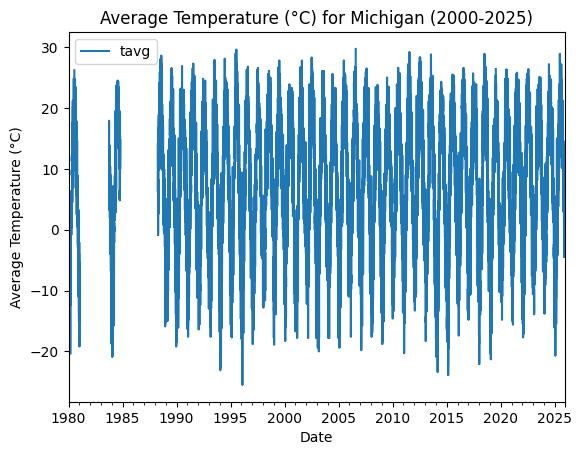

In [21]:
Plot(data, 'tavg', 'Average Temperature (°C)')

#### Maximum

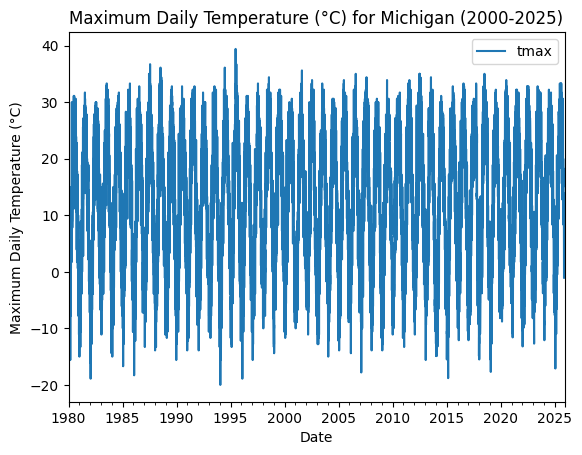

In [22]:
Plot(data, 'tmax', 'Maximum Daily Temperature (°C)')

#### Minimum

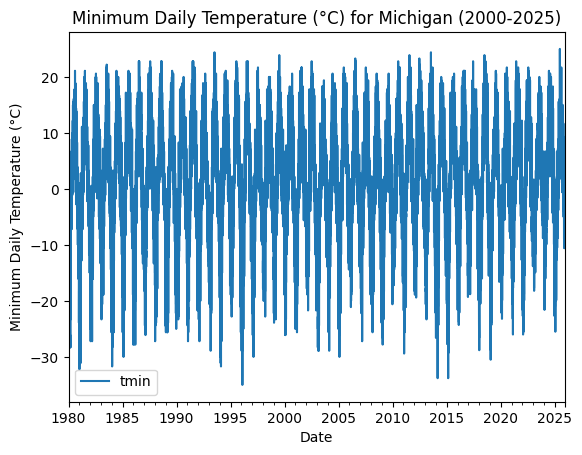

In [23]:
Plot(data, 'tmin', 'Minimum Daily Temperature (°C)')

### Precipitation

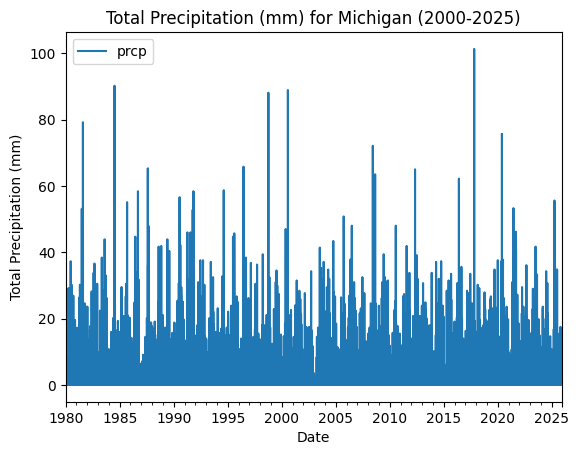

In [24]:
Plot(data, 'prcp', 'Total Precipitation (mm)')

### Average Wind Speed

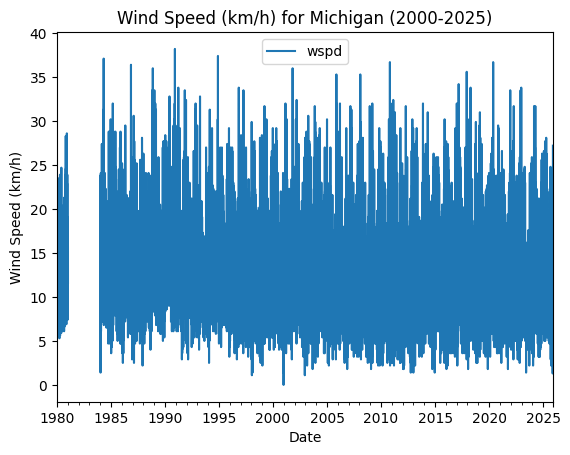

In [25]:
Plot(data, 'wspd', 'Wind Speed (km/h)')

### Wind Peak Dust

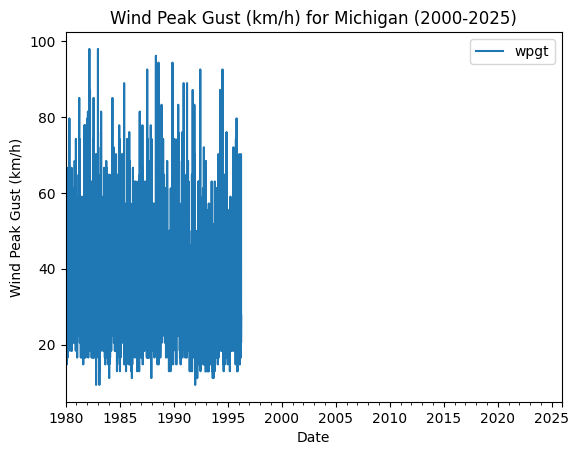

In [27]:
Plot(data, 'wpgt', 'Wind Peak Gust (km/h)')

### Wind from Direction
- no plot as there are no values in the dataset

### Sea-Level Air Pressure

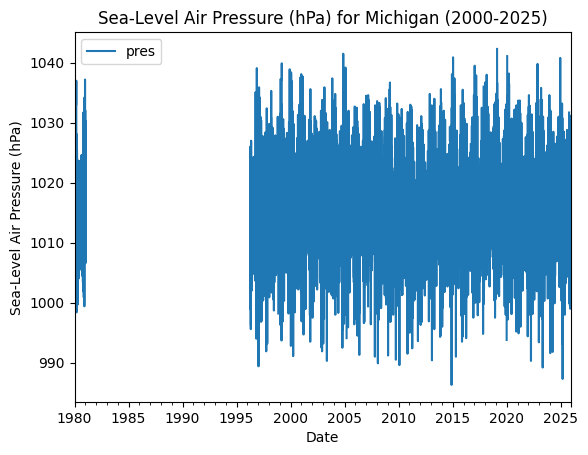

In [28]:
Plot(data, 'pres', 'Sea-Level Air Pressure (hPa)')

### Snow Depth

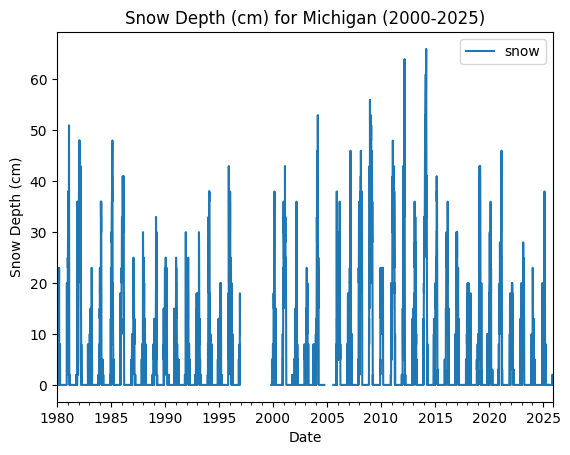

In [29]:
Plot(data, 'snow', 'Snow Depth (cm)')

### Sunshine Duration

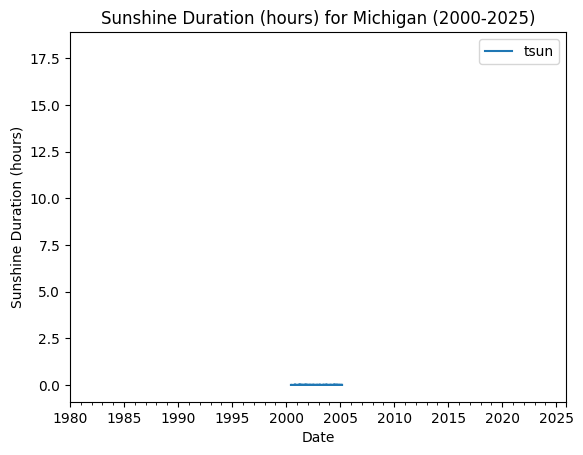

In [30]:
Plot(data, 'tsun', 'Sunshine Duration (hours)')

# 5. Preprocessing

## 5.1. Removing Columns


The following columns will be removed:
- tsun: not enough data to derive meaningful resulsts
- wpgt: collection of data stopped in 1976
- wdir: only null values

In [32]:
cols_to_remove = ['tsun', 'wpgt', 'wdir']

data_remcol = data.drop(columns=[c for c in cols_to_remove if c in data.columns])

data_remcol

,tavg,tmin,tmax,prcp,snow,wspd,pres
time,,,,,,,
1980-01-01,<NA>,-2.8,1.1,0.0,2.0,<NA>,<NA>
1980-01-02,<NA>,-7.2,-0.6,0.0,2.0,<NA>,<NA>
1980-01-03,<NA>,-13.3,-4.4,0.0,2.0,<NA>,<NA>
1980-01-04,<NA>,-16.7,-3.9,0.0,2.0,<NA>,<NA>
1980-01-05,<NA>,-12.8,-2.2,0.0,2.0,<NA>,<NA>
...,...,...,...,...,...,...,...
2025-11-23,3.2,-4.0,8.0,0.0,<NA>,15.0,1015.0
2025-11-24,3.4,-6.0,10.0,0.0,<NA>,9.4,1017.5
2025-11-25,6.0,4.0,8.3,1.3,<NA>,3.8,<NA>


## 5.2. Computation of missing values

### Average Temperature
- using tmin and tmax to compute the daily average

In [33]:
# fill missing tavg using vectorized operations
data_remcol['tavg'] = data_remcol['tavg'].fillna(
    (data_remcol['tmin'] + data_remcol['tmax']) / 2
)

# ensure numeric dtype
data_remcol['tavg'] = pd.to_numeric(data_remcol['tavg'], errors='coerce')

data_clear = data_remcol


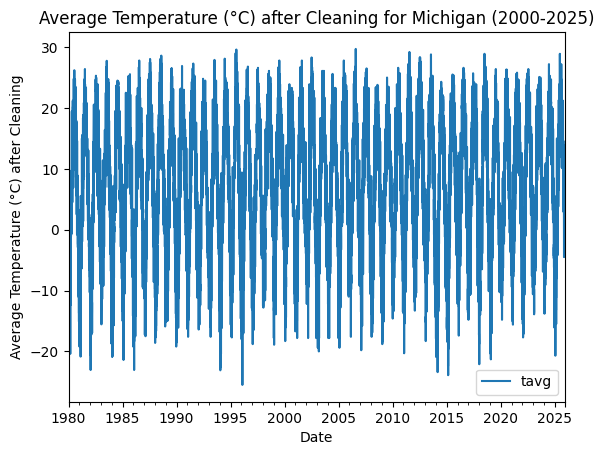

In [34]:
# Plot as sanity check
Plot(data_clear, 'tavg', 'Average Temperature (°C) after Cleaning')

### Sea Level Air Pressure
- using daily average from complete years in the dataset

In [35]:
df = data_remcol.copy()

df['doy'] = df.index.dayofyear
df['year'] = df.index.year

# get years with sufficient data
valid_years = (
    df['pres']
    .notna()
    .groupby(df['year'])
    .sum()
)

usable_years = valid_years[valid_years > 300].index  # years with full coverage

print("Usable years for climatology:", usable_years.tolist())

# build climatology from usable years
clim_source = df[df['year'].isin(usable_years)]

pressure_clim = clim_source.groupby('doy')['pres'].mean()

# fill missing data using climatology
df['pres_filled'] = df.apply(
    lambda row: pressure_clim[row['doy']] if pd.isna(row['pres']) else row['pres'],
    axis=1
)

# smooth filled data with rolling mean
df['pres_filled'] = (
    df['pres_filled']
    .rolling(window=30, center=True, min_periods=1)
    .mean()
)

df['pres'] = df['pres_filled']
df = df.drop(columns=['pres_filled', 'doy', 'year'])

data_clear = df

Usable years for climatology: [1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]


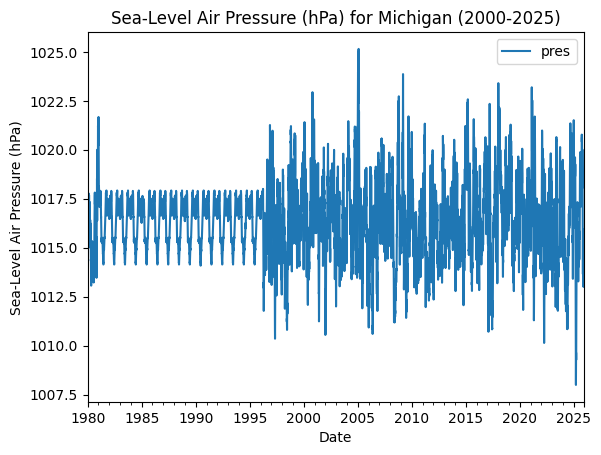

In [36]:
# Plot as sanity check
Plot(data_clear, 'pres', 'Sea-Level Air Pressure (hPa)')

### Wind Speed
- using random forest trained on other weather variables

In [42]:
df = data_clear.copy()

predictors = ['tavg', 'tmin', 'tmax', 'pres', 'prcp', 'snow']

# ensure numeric
df[predictors] = df[predictors].apply(pd.to_numeric, errors='coerce')

# impute predictors first
df[predictors] = df[predictors].fillna(method='ffill').fillna(method='bfill')
df[predictors] = df[predictors].fillna(df[predictors].mean())

# split data
train = df[df['wspd'].notna()]
test  = df[df['wspd'].isna()]

# train model
model = RandomForestRegressor(n_estimators=300, random_state=42)
model.fit(train[predictors], train['wspd'])

# predict
df.loc[test.index, 'wspd'] = model.predict(test[predictors])

# light smoothing
df['wspd'] = df['wspd'].rolling(3, center=True, min_periods=1).mean()

data_clear = df


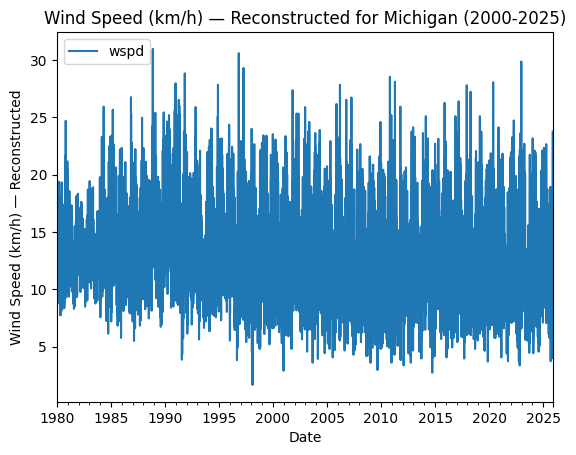

In [43]:
# Plot as sanity check
Plot(data_clear, "wspd", "Wind Speed (km/h) — Reconstructed")

### Snow Depth
- using daily avergaes from years with sufficient data

In [44]:
df = data_clear.copy()
df.index = pd.to_datetime(df.index)

df['doy'] = df.index.dayofyear

snow_climatology = df.loc[df['snow'].notna(), ['snow', 'doy']].groupby('doy').mean()['snow']

missing_ranges = [
    ('1997-01-01', '2000-12-31'),
    ('2004-01-01', '2006-12-31')
]

df['snow_filled'] = df['snow']

for start, end in missing_ranges:
    mask = (df.index >= start) & (df.index <= end)
    df.loc[mask, 'snow_filled'] = df.loc[mask, 'doy'].apply(lambda d: snow_climatology[d])

df['snow_filled'] = df['snow_filled'].rolling(7, center=True, min_periods=1).mean()

df['snow'] = df['snow_filled']
df = df.drop(columns=['snow_filled', 'doy'])

data_clear = df

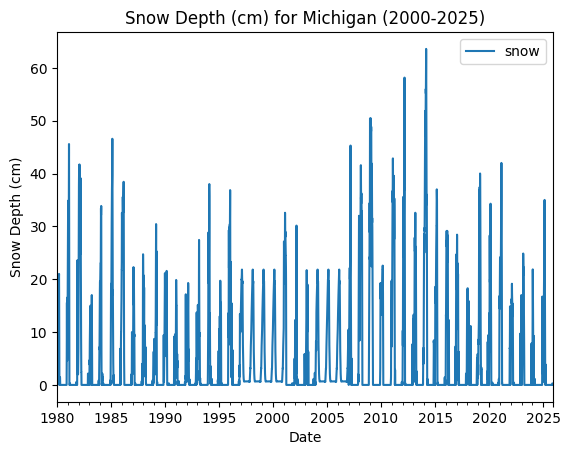

In [45]:
# Plot as sanity check
Plot(data_clear, 'snow', 'Snow Depth (cm)')

### ***Findings:***
- The missing values for the following columns were successfully estimated using appropriate imputation methods, providing a sufficiently complete dataset for further analysis.
    - Snow Depth
    - Wind Speed
    - Total Precipitation
    - Average Temperature
    - Maximum Daily Temperature
    - Minimum Daily Temperature

- Sea-Level Air Pressure contains excessive missing values, and reliable estimation was not possible, this column will be dropped.


### Dropping Sea-level column

In [46]:
data_clear.drop(columns=['pres'], inplace=True)
data_clear

,tavg,tmin,tmax,prcp,snow,wspd
time,,,,,,
1980-01-01,-0.85,-2.8,1.1,0.0,2.000000,13.561500
1980-01-02,-3.9,-7.2,-0.6,0.0,2.000000,13.933889
1980-01-03,-8.85,-13.3,-4.4,0.0,2.000000,13.908000
1980-01-04,-10.3,-16.7,-3.9,0.0,3.857143,14.128556
1980-01-05,-7.5,-12.8,-2.2,0.0,5.000000,15.247333
...,...,...,...,...,...,...
2025-11-23,3.2,-4.0,8.0,0.0,0.000000,11.300000
2025-11-24,3.4,-6.0,10.0,0.0,0.000000,9.400000
2025-11-25,6.0,4.0,8.3,1.3,0.000000,11.166667


In [47]:
data_clear.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16768 entries, 1980-01-01 to 2025-11-27
Freq: D
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tavg    16768 non-null  Float64
 1   tmin    16768 non-null  Float64
 2   tmax    16768 non-null  Float64
 3   prcp    16768 non-null  Float64
 4   snow    16768 non-null  float64
 5   wspd    16768 non-null  float64
dtypes: Float64(4), float64(2)
memory usage: 1.5 MB


# 6. Export File

In [50]:
data_clear.to_csv(r'C:\Users\Celina Binder\Documents\github respository\TIS3IL-WS25-Project\data\processed\processed_weather_data_michigan.csv')